# Практика

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

- 1) Загружаем данные. Имя файлов: data/output_10k-*.npz

   Информация о хитах, времени первого попадания (FHT), энерговыделению по ключу hits
   
   Информация о энергии, координатам и импульсе первичной частицы по ключу primaries

In [ ]:
files = os.listdir('data')
files.sort()
print(files)

In [ ]:
hits, primaries = [], []
for file in tqdm(files):
    data = np.load(f"data/{file}", allow_pickle=True)
    hits = np.append(hits, data['hits'])
    primaries = np.append(primaries, data['primaries'])

- 2) Ознакомьтесь с размерностью массивов и их структурой (*полезно: .shape)

- 3) Создадим список со всеми направляющими косинусами для наших событий. Косинус угла с отрицательным направлением оси z (который указывает на направление каскада) будет для нас целевой переменной. 

In [ ]:
cos_theta = []

for evt in primaries:
    pr = np.sqrt(evt['px']**2 + evt['py']**2 + evt['pz']**2)
    cos_theta.append(-evt['pz'] / pr)

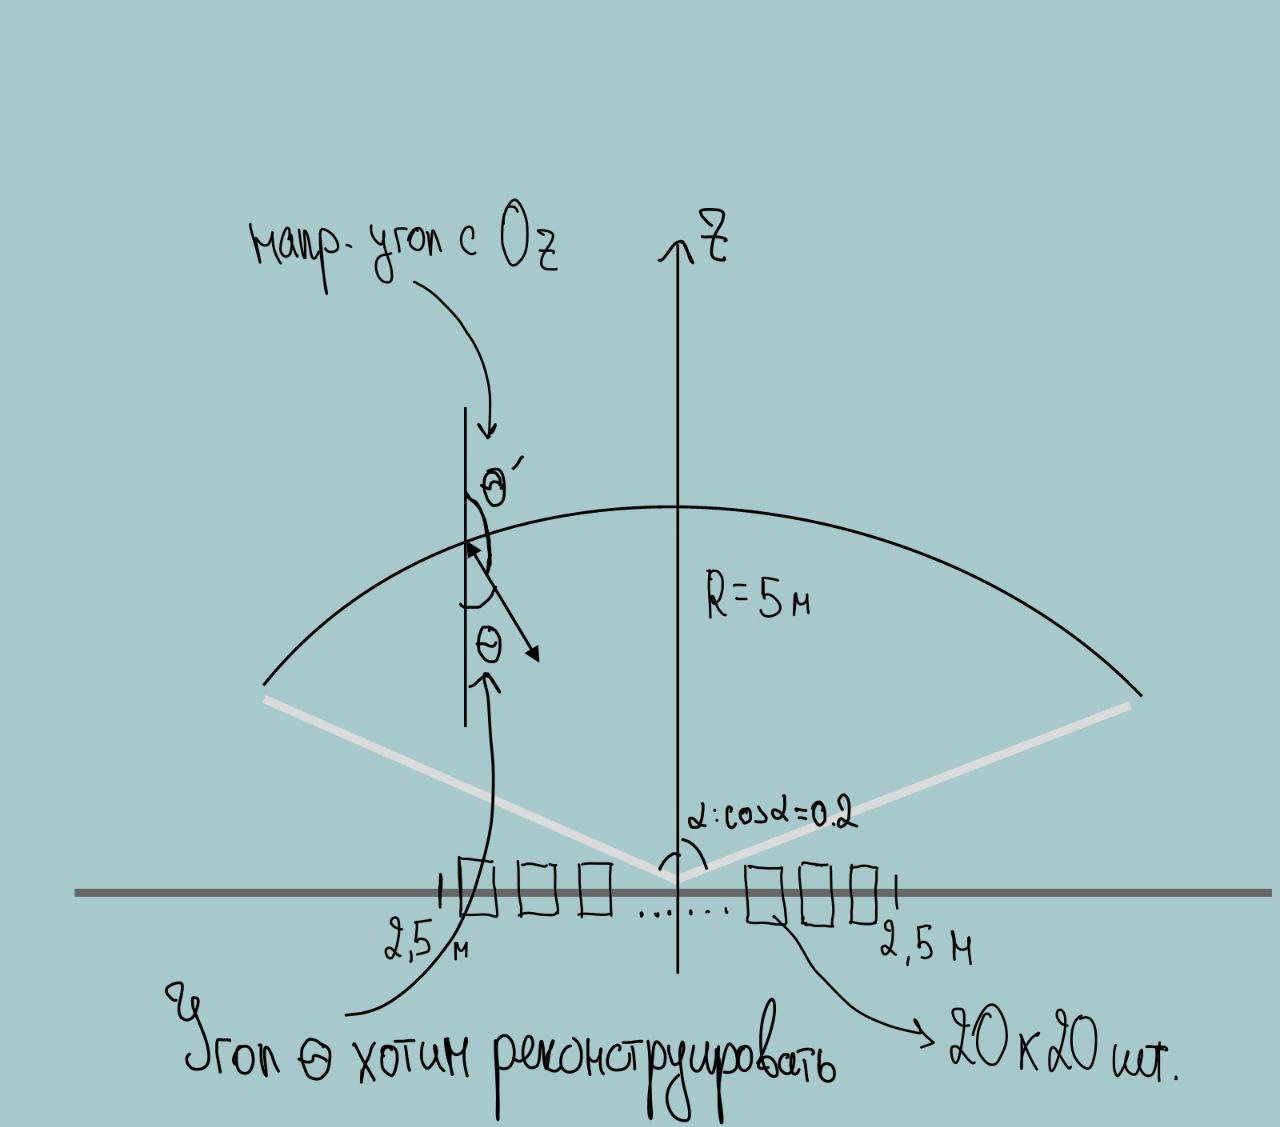

- 4) Давайте посмотрим на распределение косинусов тета: 

In [ ]:
import plotly.io as pio
import plotly.graph_objs as go
pio.templates.default = 'plotly_white'

fig = go.Figure()

trace = lambda cos_angle, name, color: \
    go.Histogram(
        x=cos_angle,
        xbins=dict(size=0.02),
        opacity=0.7,
        histnorm='probability',
        name=name,
        marker=dict(color=color)
    )
    
fig.add_trace(trace(cos_theta, r"$\cos{\theta} $", 'darkred'))

for angle in [0, 90]:
    fig.add_vline(x=np.cos(np.deg2rad(angle)),
                  line_width=3,
                  line_dash="dash",
                  line_color="black",
                  annotation_text=" "+str(angle)
    )

fig.update_layout(
    barmode='overlay',
    legend=dict(
        yanchor="top",
        itemwidth=30,
        y=0.99,
        xanchor="right",
        x=0.16,
        bordercolor="Black",
        borderwidth=2,
        font=dict(
            family="Times New Roman",
            color="black",
            size=20
        ),
    ),
    showlegend=True,
    font=dict(
            family="Times New Roman",
            color='black',
            size=20,
    )
)

fig.show()

- 5) hits — это список сработавших ячеек в событии: [ [ix, iy, nHits, fht, Edep],  ... ]. Обращаться к ним можно по соответствующему ключу (ix, iy, nHits, fht, Edep)

#### Давайте визуалируем событие. Напишите функцию отрисовки сетки с модулями, используя Plotly.

- Функция будет следующего вида: 
```python 
    def plot_event_2d(hit, primary):
        pass
``` 

- Будем использовать два канала информации --- количество хитов в каждом модуле и время первого попадания (first hit time). Будем изображать их отдельно рядом друг с другом (plotly.subplots.make_subplots):
```python
    fig = make_subplots(
        rows=1, cols=2, column_widths=[0.5, 0.5]
    )
```
- Для визуализации зависимости значения от цвета можно использовать:
```python 
marker=dict(colorscale=your_colorscale)
```
Список цветовых гамм: https://plotly.com/python/builtin-colorscales/

- Для создания пустой сетки предлагаю использовать просто Scatter: 
```python 
    x_size = 20
    y_size = 20
    x_grid = np.arange(x_size)
    y_grid = np.arange(y_size)
    grid =  np.array(
        list(itertools.product(x_grid, y_grid))
    ) 
    
    grid_trace = go.Scatter(
                x=grid[:, 0],
                y=grid[:, 1],
                mode='markers',
                showlegend=False,
                marker=dict(
                    symbol='square',
                    color='rgb(100, 100, 100)',
                    opacity=0.8,
                    size=12
                )
            )
    
    fig.add_trace(grid_trace, row=1, col=1)
    fig.add_trace(grid_trace, row=1, col=2)
```

- Изобразим кол-во хитов и время первого попадания на базовой сетке, которую мы задали выше, используя различные цветовые гаммы. Используем go.Scatter()

- Добавим истинное значение косинуса угла тета в заголовок графика, используя:
```python 
    fig.update_layout(
        title = your_title
    )
```

- Укажим имя кривой в легенде графика с помощью аргумента name в go.Scatter

In [ ]:
import itertools
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_dark'

def plot_event_2d(hit, primary):
    fig = make_subplots(
        rows=1, cols=2, column_widths=[0.5, 0.5]
    )
    
    x_size = 20
    y_size = 20
    x_grid = np.arange(x_size)
    y_grid = np.arange(y_size)
    grid =  np.array(
        list(itertools.product(x_grid, y_grid))
    ) 
    
    nHits = list(hit['nHits'].round(2))
    FHT = list(hit['fht'].round(2))

    str1 = ', '.join(
        "nHits: " + str(nHits[i]) + " FHT: " + str(FHT[i])
        for i in range(len(nHits))
    )
    scatter_text = str1.split(", ")

    
    grid_trace = go.Scatter(
                x=grid[:, 0],
                y=grid[:, 1],
                mode='markers',
                showlegend=False,
                marker=dict(
                    symbol='square',
                    color='rgb(100, 100, 100)',
                    opacity=0.8,
                    size=12
                )
            )
    
    fig.add_trace(grid_trace, row=1, col=1)
    fig.add_trace(grid_trace, row=1, col=2)
        
    trace_event = lambda channel, colorscale: \
        go.Scatter(
            x=hit['ix'],
            y=hit['iy'],
            mode='markers',
            name=channel,
            text=scatter_text,
            marker=dict(
                symbol='square',
                color=hit[channel],
                colorscale=colorscale,
                size=12
            )
        )
    
    fig.add_trace(trace_event('nHits', 'reds'), row=1, col=1)
    fig.add_trace(trace_event('fht', 'blues'), row=1, col=2)

    fig.update_layout(
        title="cos(theta) " + str(np.round(-primary['pz'], 2)),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="right",
            x=1
        )
    )

    fig.show()

In [ ]:
n1 = np.random.randint(primaries.shape[0])
n2 = np.random.randint(primaries.shape[0])

plot_event_2d(hits[n1], primaries[n1])
plot_event_2d(hits[n2], primaries[n2])

### Посмотрим на более подробную визуализацию...

In [ ]:
def plot_event(hit, primary):
    fig = make_subplots(
        rows=1, cols=3, column_widths=[0.33, 0.33, 0.33],
        specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]]
    )    
    
    theta = np.linspace(0, 2*np.pi,100)
    phi = np.linspace(0, np.arccos(0.2), 100)
    x = np.outer(np.cos(theta),np.sin(phi))
    y = np.outer(np.sin(theta),np.sin(phi))
    z = np.outer(np.ones(100),np.cos(phi))
    R = (primary['x']**2 + primary['y']**2 + primary['z']**2)**0.5
    
    colorscale_pe=[
        'rgb(150, 30, 70)', 'rgb(255, 200, 70)', 'rgb(255, 255, 100)'
    ]
    
    x_size = 5
    y_size = 5
    x_grid = np.linspace(0, x_size, 20)
    y_grid = np.linspace(0, y_size, 20)
    grid =  np.array(
        list(itertools.product(x_grid, y_grid))
    ) 
        
    nHits = list(hit['nHits'].round(2))
    Edep = list(hit['Edep'].round(2))
    FHT = list(hit['fht'].round(2))

    str1 = ', '.join(
        "nHits: " + str(nHits[i]) + "Edep: " + str(1000*Edep[i]) + " KeV" + " FHT: " + str(FHT[i])
        for i in range(len(nHits))
    )
    scatter_text = str1.split(", ")
    
    grid_trace = go.Scatter3d(
                    x=grid[:, 0],
                    y=grid[:, 1],
                    z=np.zeros(grid.shape[0]),
                    mode='markers',
                    showlegend=False,
                    marker=dict(
                        symbol='square',
                        color='rgb(100, 100, 100)',
                        opacity=0.8
                    )
                )
    
    for i in range(1, 4):
        fig.add_trace(grid_trace, row=1, col=i)
    
    trace_event = lambda channel, colorscale: \
        go.Scatter3d(
            x=hit['ix'] / 4,
            y=hit['iy'] / 4,
            z=np.zeros(x_size),
            mode='markers',
            name=channel,
            text=scatter_text,
            marker=dict(
                symbol='square',
                color=hit[channel],
                colorscale=colorscale,
            )
        )
    
    fig.add_trace(trace_event('nHits', colorscale_pe), row=1, col=1)
    fig.add_trace(trace_event('Edep', colorscale_pe), row=1, col=2)
    fig.add_trace(trace_event('fht', 'ice'), row=1, col=3)
    
    trace_vertex = lambda legend: go.Scatter3d(
                x=[primary['x']+2.5],
                y=[primary['y']+2.5],
                z=[primary['z']],
                mode='markers',
                text="cos(theta) " + str(np.round(-primary['pz'], 2)),
                marker=dict(size=7,
                            color='white',
                            opacity=1),
                name='cos(theta) = ' + str(np.round(-primary['pz'], 2)),
                showlegend=legend
    )

    fig.add_trace(trace_vertex(True), row=1, col=1)
    fig.add_trace(trace_vertex(False), row=1, col=2)
    fig.add_trace(trace_vertex(False), row=1, col=3)
    
    trace_direction = lambda legend: go.Scatter3d(
                x=[primary['x'] + 2.5, primary['x'] + 2.5 + 7*primary['px']],
                y=[primary['y'] + 2.5, primary['y'] + 2.5 + 7*primary['py']],
                z=[primary['z'], primary['z'] + 7*primary['pz']],
                mode='lines',
                text="Dir.",
                line=dict(
                    dash='dash',
                    width=3,
                    color='gold'
                ),
                name="Direction",
                showlegend=legend
    )

    fig.add_trace(trace_direction(True), row=1, col=1)
    fig.add_trace(trace_direction(False), row=1, col=2)
    fig.add_trace(trace_direction(False), row=1, col=3)
    
    trace_surface = go.Surface(
                x=x * R + 2.5,
                y=y * R + 2.5,
                z=z * R,
                opacity=0.3,
                showscale=False,
                colorscale=['rgb(2, 2, 2)', 'rgb(4, 4, 4)'],
                name=''
    )

    for i in range(1, 4):
        fig.add_trace(trace_surface, row=1, col=i)
            
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="right",
            x=1
        )
    )
    
    fig.show()

In [ ]:
n1 = np.random.randint(primaries.shape[0])
n2 = np.random.randint(primaries.shape[0])

plot_event(hits[n1], primaries[n1])
plot_event(hits[n2], primaries[n2])

- 6) Для реконструкции косинуса угла тета будем использовать подход основанный на агрегированных признаках. То есть подсчитаем некоторые, обобщающие сигнал с оптических модулей, характеристики, как для каналов с кол-вом хитов и выд. энергией, так и для временного канала.  

Такими характеристиками могут быть, например: 

- 1) Общее кол-во хитов на всех оптических модулях
- 2) Вся выделившаяся энергия
- 3) Кол-во загоревшихся оптических модулей
- 4) Разница между максимальным и минимальным значениями FHT
- 5) интерквартильный размах для FHT
- 6) Дисперсия времён первого попадания для загоревшихся опт. модулей
- 7) Вариация расстояний модулей от геом. центра загоревшихся модулей
- 8) Вариация расстояний модулей от геом. центра загоревшихся модулей (взвешенного с кол-вом хитов)
- 9) Вариация расстояний модулей от геом. центра загоревшихся модулей (взвешенного с выд. энергией)
- 10) ... Ваши идеи

**Подсчитаем их:**

In [ ]:
N = hits.shape[0]
nHits = np.zeros(N)
Edeps = np.zeros(N)
nModules = np.zeros(N)
fht_maxmin = np.zeros(N)
fht_iqr = np.zeros(N)
fht_std = np.zeros(N)
std_dr = np.zeros(N)
weighted_hits_std_dr = np.zeros(N)
weighted_edep_std_dr = np.zeros(N)

for i in tqdm(range(N)):
    try:
        nHits[i] = np.sum(hits[i]['nHits']) # полное кол-во хитов на всех модулях
        Edeps[i] = np.sum(hits[i]['Edep']) # вся выделевшаяся энергия на всех модулях
        nModules[i] = int(hits[i]['nHits'].shape[0]) # кол-во загоревшихся модулей
        fht_maxmin[i] = np.max(hits[i]['fht']) - np.min(hits[i]['fht']) # разница между макс. и мин. FHT
        fht_iqr[i] = np.percentile(hits[i]['fht'], 75) - np.percentile(hits[i]['fht'], 25) # интерквартильный размах для FHT
        fht_std[i] = np.std(hits[i]['fht']) # дисперсия (*корень из дисперсии)
        
        dr = np.vstack(
                    (hits[i]['ix'] - hits[i]['ix'].mean(),
                     hits[i]['iy'] - hits[i]['iy'].mean())
             ).T
        std_dr[i] = np.std(dr) # вариация расстояний от геом. центра
        
        x_ch = np.sum(hits[i]['ix'] * hits[i]['nHits']) / nHits[i]
        y_ch = np.sum(hits[i]['iy'] * hits[i]['nHits']) / nHits[i]
        weighted_hits_dr = np.vstack(
                    (hits[i]['ix'] - x_ch,
                     hits[i]['iy'] - y_ch)
             ).T
        weighted_hits_std_dr[i] = np.std(weighted_hits_dr) # вариация расстояний от геом. центра (взвешенного с хитами)


        x_ce = np.sum(hits[i]['ix'] * hits[i]['Edep']) / Edeps[i]
        y_ce = np.sum(hits[i]['iy'] * hits[i]['Edep']) / Edeps[i]
        weighted_edep_dr = np.vstack(
                    (hits[i]['ix'] - x_ce,
                     hits[i]['iy'] - y_ce)
             ).T
        weighted_edep_std_dr[i] = np.std(weighted_edep_dr) # вариация расстояний от геом. центра (взвешенного с выд. энергией)

    except ValueError:
        continue

- 7) Сохраним наши признаки в формате pandas DataFrame. То есть в качестве колонок у нас будут признаки, а также добавим последнюю колонку с истинными косинусами тета: cos_theta.

In [ ]:
features_df = pd.DataFrame()
features_df['nHits'] = nHits
features_df['Edeps'] = Edeps
features_df['nModules'] = nModules
features_df['fht_maxmin'] = fht_maxmin
features_df['fht_iqr'] = fht_iqr
features_df['fht_std'] = fht_std
features_df['std_dr'] = std_dr
features_df['weighted_hits_std_dr'] = weighted_hits_std_dr
features_df['weighted_edep_std_dr'] = weighted_edep_std_dr
features_df['cos_theta'] = cos_theta
features_df

In [ ]:
features_df.info()

**Обратите внимание, что бывают события, в которых не было ни одного хита! Давайте отсеим события, у которых загорелось хотя бы три ячейки. То есть установим условие nModules >= 3.**

In [ ]:
ser_nModules = pd.Series(nModules)
df = features_df.iloc[ser_nModules[ser_nModules >= 3].index]
df.info()

- 8) Теперь давайте посмотрим на распределения наших признаков

In [ ]:
pio.templates.default = 'plotly_white'

def bar_trace(feature, color):
    counts, bins = np.histogram(df[feature], bins=75)
    bins = 0.5 * (bins[:-1] + bins[1:])
    bar = go.Bar(
        x=bins,
        y=counts,
        name=feature,
        offset=0,
        marker_color=color
    )
    
    return bar

def plot_distrs(df):
    colors = ['darkblue', 'darkred', 'darkgreen',
              'darkmagenta', 'darkseagreen', 'darkviolet',
              'darkorchid', 'darksalmon', 'darkslategray']
    
    fig_place = [[1, 1], [1, 2], [1, 3],
                 [2, 1], [2, 2], [2, 3],
                 [3, 1], [3, 2], [3, 3]]

    fig = make_subplots(
            rows=3, cols=3,
            subplot_titles = df.columns[:-1],
            vertical_spacing=0.2
    )

    for i in range(len(df.columns[:-1])):
        fig.add_trace(bar_trace(df.columns[i], colors[i]),
                      row=fig_place[i][0], col=fig_place[i][1])

    fig.update_layout(
        bargap=0,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.05,
            xanchor="right",
            x=1.1
        )
    )

    fig.show()

In [ ]:
plot_distrs(df)

- 9) Избравимся от выбросов, обрежим хвосты:

In [ ]:
df = df[df.fht_iqr < np.percentile(df.fht_iqr, 99.85)]
df = df[df.fht_maxmin < np.percentile(df.fht_maxmin, 99.85)]
df = df[df.fht_std < np.percentile(df.fht_std, 99.85)]
df = df[df.nHits < np.percentile(df.nHits, 99.85)]

In [ ]:
plot_distrs(df)

In [ ]:
df.info()

- 10) Посмотрите на корреляцию между каким-нибудь признаком и целевой переменной (cos_theta). Давайте использовать np.corrcoef()

- 11) Теперь посмотрим на матрицу корреляций: 

In [ ]:
pio.templates.default = 'plotly_white'

corr_matrix = df.corr()

fig = go.Figure(data=go.Heatmap(
          x = corr_matrix.index,
          y = corr_matrix.columns,
          z = corr_matrix.values,
          type = 'heatmap',
          xgap=0.25,
          ygap=0.25,
          colorscale = 'Inferno',
          name='Real')
)

fig.update_layout(
    width=600,
    height=600,
    xaxis_nticks=corr_matrix.index.shape[0],
    yaxis_nticks=corr_matrix.index.shape[0],
    font=dict(
        family="Times New Roman",
        size=15,
        color="Black"
    )
)

fig.show()

- 12) Посмотрим на зависимости более детально: с помощью go.Historgam2d, то есть 2D гистограммы. 

In [ ]:
def corr_2d_vis(x, y, xaxis_title, yaxis_title):

    fig = go.Figure()

    fig.add_trace(
        go.Histogram2d(
            x=x,
            y=y, 
            colorscale='inferno',
        )
    )

    fig.update_layout(
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        showlegend=True,
        font=dict(
            family="Times New Roman",
            size=20,
            color='black'
        ),
        title=dict(
            xanchor='center',
            x=0.5,
        )
    )

    fig.show()

- 13) Вызовите функцию corr_2d_vis для различных признаков. Посмотрите на зависимости между признаком и косинусом тета 

### Перейдем к обучении моделей:

- 14) Возьмите XGBRegressor из xgboost. 
- Разделите данные на тренировочные и тестовые, используя sklearn.model_selection.train_test_split
- Создайте объект XGBRegressor: model = XGBRegressor(...)
- Обучите базовую модель градиентного бустинга над решающими деревьями со следующими гиперпараметрами:
    - max_depth=7,
    - learning_rate=0.08,
    - n_estimators=140,
    - random_state=22,
- Для обучения модели используем метод model.fit()

In [ ]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :df.shape[1]-1]
y = df.iloc[:, df.shape[1]-1]

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(
    
)

- 15) Используем нашу функции для 2D гистограмм для отрисовки результатов предсказания модели

In [ ]:
pred_df = pd.DataFrame([model.predict(X_test), y_test]).T
pred_df.columns = ['cos_theta_predict', 'cos_theta_true']

In [ ]:
corr_2d_vis(pred_df.cos_theta_predict, pred_df.cos_theta_true,
            'Reconstructed cos(theta)', 'True cos(theta)')

- 16) Теперь более внимательно посмотрим на ошибки

In [ ]:
dCos = (pred_df.cos_theta_true - pred_df.cos_theta_predict) / pred_df.cos_theta_true * 100

In [ ]:
corr_2d_vis(pred_df.cos_theta_true, dCos, r'$\large \cos{\theta}_{true}$',
            r"$\large d\cos{\theta} = \frac{\cos{\theta}_{true} - \cos{\theta}_{pred}}{\cos{\theta}_{true}} \cdot 100, [\%]$",
)

- 17) Выведите основные метрики для регрессии (MAPE, RMSE, MAE, R2, ...). Используйте sklearn.metrics или напишите функции самостоятельно.

- 18) Значимость признаков на основе shap

In [ ]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)